In [51]:
import os
import ast
import csv
import ntpath 
import twarc
import json
import jsonlines

import pandas as pd
import compare_communities

from pandas import DataFrame
from typing import Any, Dict
from community import community_louvain
import networkx as nx

In [52]:
# CONSTANTS
DATA_PATH_PART_1 = "./tweets_part_1.json"
DATA_PATH_PART_2 = "./tweets_part_2.json"
DEBUG=False

In [53]:
# Utils Functions

def flatten(list_of_lists):
    """Takes a list of lists and turns it into a list of the sub-elements"""
    return [item for sublist in list_of_lists if type(sublist) == list for item in sublist]

def get_most_used(values, rank=1):
    if len(set(values)) < rank: return None
    counts = [(v, values.count(v)) for v in set(values)]
    counts.sort(key=lambda t: t[1], reverse=True)
    return counts[rank-1][0]

def read_tweets(file_path: str):
    tweets = []
    with jsonlines.open(file_path) as reader:
        for obj in reader:
            tweets.append(obj)
    return tweets

def extract_parent_dir(filepath, default_dir='./'):
    if not filepath:
        return default_dir

    return os.path.abspath(os.path.join(filepath, os.pardir))

def log(msg):
    if DEBUG: eprint(msg)

In [270]:
# Necessary Functions

def mentioned_ids_from(tweet, desired_field='id'):
    try:
        mention_entities = tweet['entities']['mentions']
        return [mention['id'] for mention in mention_entities]
    except KeyError as e:
        print(f"KeyError {e}")

def expanded_urls_from(tweet):
    try:
        url_entities = tweet['entities']['urls']
        return url_entities
    except KeyError as e:
        print(f"KeyError {e}")
        
def lowered_hashtags_from(tweet):
    try:
        ht_entities = tweet['entities']['hashtags']
        ht_entities_formatted = [ht['tag'].lower() 
                                 for ht in ht_entities]
        return ht_entities_formatted
    except KeyError as e:
        print(f"KeyError {e}")

def obtain_replied_user_id(tweet):
    try:
        reply_to_user_id = tweet['in_reply_to_user_id']
        return reply_to_user_id
    except KeyError as e:
        print(f"KeyError {e}")

def analyse_tweet_data(tweets_dataset: DataFrame,
                       df_tweets_formatted: DataFrame) -> Dict[str, Any]:
    
    # Copying Datasets
    tweets_dataset = tweets_dataset.copy()
    df_tweets_formatted = df_tweets_formatted.copy()
    
    # Defining Dict Result
    dict_result = {}
    # Data Understanding
    ## Metrics
    tweets_dataset['retweet_count'] = tweets_dataset['public_metrics'].apply(lambda x: x['retweet_count'])
    tweets_dataset['reply_count'] = tweets_dataset['public_metrics'].apply(lambda x: x['reply_count'])
    tweets_dataset['like_count'] = tweets_dataset['public_metrics'].apply(lambda x: x['like_count'])
    tweets_dataset['quote_count'] = tweets_dataset['public_metrics'].apply(lambda x: x['quote_count'])
    tweets_dataset['impression_count'] = tweets_dataset['public_metrics'].apply(lambda x: x['impression_count'])

    df_tweets_formatted['mentions'] = df_tweets_formatted['twitter_response'].apply(mentioned_ids_from)
    df_tweets_formatted['hashtags'] = df_tweets_formatted['twitter_response'].apply(lowered_hashtags_from)
    df_tweets_formatted['urls'] = df_tweets_formatted['twitter_response'].apply(expanded_urls_from)
    df_tweets_formatted['hashtags_count'] = [len(i) if i != None else None 
                                             for i in df_tweets_formatted['hashtags'].tolist()]

    df_tweets_formatted['urls_count'] = [len(i) if i != None else None 
                                         for i in df_tweets_formatted['urls'].tolist()]

    all_authors = [i for i in tweets_dataset['author_id'].tolist()
                  if type(i) != float]
    all_replies = [i for i in tweets_dataset['in_reply_to_user_id'].tolist()
                   if type(i) != float]
    all_mentions = flatten(df_tweets_formatted['mentions'].tolist())
    all_hashtags = flatten(df_tweets_formatted['hashtags'].tolist())
    all_urls_pre = flatten(df_tweets_formatted['urls'].tolist())
    all_urls = [url_dict['url'] for url_dict in all_urls_pre]

    tweets_count = tweets_dataset.shape[0]
    retweet_count = tweets_dataset['retweet_count'].sum()
    reply_count = tweets_dataset['reply_count'].sum()
    like_count = tweets_dataset['like_count'].sum()
    quote_count = tweets_dataset['quote_count'].sum()
    impression_count = tweets_dataset['impression_count'].sum()

    hashtags_amount =  df_tweets_formatted['hashtags_count'].sum()
    urls_amount = df_tweets_formatted['urls_count'].sum()

    most_profilic_author = get_most_used(all_authors)
    most_prolific_author_tweet_count = all_authors.count(most_profilic_author)

    most_replied_to_tweet = get_most_used(all_replies)
    most_replied_to_tweet_count = all_replies.count(most_replied_to_tweet)

    most_mentioned_author = get_most_used(all_mentions)
    most_mentioned_author_count = all_mentions.count(most_mentioned_author)

    unique_hashtags = len(set(all_hashtags))
    most_used_hashtag = get_most_used(all_hashtags)
    most_used_hashtag_count = all_hashtags.count(most_used_hashtag)
    next_most_used_hashtag = get_most_used(all_hashtags, 2)
    next_most_used_hashtag_count = all_hashtags.count(next_most_used_hashtag)

    most_used_url = get_most_used(all_urls)
    most_used_url_count = all_urls.count(most_used_url)
    
    # Setting dict variables
    dict_result['tweets_count'] = tweets_count
    dict_result['retweet_count'] = retweet_count
    dict_result['reply_count'] = reply_count
    dict_result['like_count'] = like_count
    dict_result['quote_count'] = quote_count
    dict_result['impression_count'] = impression_count
    dict_result['hashtags_amount'] = hashtags_amount
    dict_result['urls_amount'] = urls_amount
    dict_result['most_profilic_author'] = most_profilic_author
    dict_result['most_prolific_author_tweet_count'] = most_prolific_author_tweet_count
    dict_result['most_replied_to_tweet_count'] = most_replied_to_tweet_count
    dict_result['most_mentioned_author_count'] = most_mentioned_author_count
    dict_result['unique_hashtags'] = unique_hashtags
    dict_result['most_used_hashtag'] = most_used_hashtag
    dict_result['most_used_hashtag_count'] = most_used_hashtag_count
    dict_result['next_most_used_hashtag'] = next_most_used_hashtag
    dict_result['next_most_used_hashtag_count'] = next_most_used_hashtag_count
    dict_result['most_used_url'] = most_used_url
    dict_result['most_used_url_count'] = most_used_url_count 
    
    return dict_result

def create_digraph_from_csv_file(csv_file: str, src_col,
                                 tgt_col, type_col, out_file,
                                 header, src_type, tgt_type, ci):
    g = nx.DiGraph()
    with open(csv_file, encoding='utf-8') as f:
        csv_reader = csv.reader(f, delimiter=',')   # handles URLs with commas
        line_count = 0
        for row in csv_reader:
            # print('linecount: %d, header: %s' % (line_count, header))
            line_count += 1
            if line_count == 1 and header:
                continue

            src = row[src_col]
            tgt = row[tgt_col]
            e_t = row[type_col]

            if ci:
                src = src.lower()
                tgt = tgt.lower()
            if src != "usr_id":
                if g.has_edge(src, tgt):
                    g[src][tgt]['weight'] += 1.0
                else:
                    if not g.has_node(src): g.add_node(src, label=src, n_type=src_type)
                    if not g.has_node(tgt): g.add_node(tgt, label=tgt, n_type=tgt_type)
                    g.add_edge(src, tgt, weight=1.0, e_type=e_t)

            line_count += 1

    if not out_file:
        out_file = os.path.join(out_dir, '%s.graphml' % extract_filename(csv_file))
    parent_dir = extract_parent_dir(out_file)
    if not os.path.exists(parent_dir):
        os.mkdir(parent_dir)
    nx.write_graphml(g, out_file)
    df_graph = nx.to_pandas_edgelist(g)
    df_graph.to_csv(f'{out_file}.csv', index=False)

    log('Wrote graph to %s' % out_file)
    
def save_tweets_pairs_txt_format(tweets_dataset, col_1, col_2, type_tweets):
    mentions_dict_dataset = []
    for i in range(len(tweets_dataset)):
        user_id = tweets_dataset.loc[i, col_1]
        mentions = tweets_dataset.loc[i, col_2]
        if (type(mentions) == list):
            for mention in mentions:
                mentions_dict_dataset.append({str(user_id): mention})
        else:
            mentions_dict_dataset.append({str(user_id): mentions})
            
    for row in mentions_dict_dataset:
        with open(f'tweets-{type_tweets}.txt', 'a') as convert_file:
            for key, value in row.items():
                 convert_file.write('%s,%s\n' % (key, value))

In [55]:
# Obtaining Tweets file for each part of tweets
# extracted

## Tweets File
tweets_part_1 = read_tweets(DATA_PATH_PART_1)
tweets_part_2 = read_tweets(DATA_PATH_PART_2)
df_tweets_part_1 = pd.DataFrame(tweets_part_1)
df_tweets_part_2 = pd.DataFrame(tweets_part_2)

## Tweets List Flattened
tweets_list_part_1 = df_tweets_part_1['data'].tolist()
tweets_list_part_2 = df_tweets_part_2['data'].tolist()
tweets_list_formatted_part_1 = flatten(tweets_list_part_1)
tweets_list_formatted_part_2 = flatten(tweets_list_part_2)

## Tweets List Formatted DataSet (It has the information returned
# by the API grouped by the different sections returned by the API)
df_tweets_formatted_part_1 = pd.DataFrame({'twitter_response': tweets_list_formatted_part_1})
df_tweets_formatted_part_2 = pd.DataFrame({'twitter_response': tweets_list_formatted_part_2})

In [56]:
# Tweets DataSet (it has the information returned by the API
# per Tweet ID)
tweets_dataset_part_1 = pd.DataFrame([tweet for 
                                      tweet in tweets_list_formatted_part_1])
tweets_dataset_part_2 = pd.DataFrame([tweet for 
                                      tweet in tweets_list_formatted_part_2])

In [57]:
# Obtaining Analysis Results
analysis_results_part_1 = analyse_tweet_data(tweets_dataset_part_1, df_tweets_formatted_part_1)
analysis_results_part_2 = analyse_tweet_data(tweets_dataset_part_2, df_tweets_formatted_part_2)

KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'entities'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'entities'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'entities'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'


KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'


In [58]:
# Printing Metrics Obtained from the Twitter Data.
analysis_results_part_1, analysis_results_part_2

({'tweets_count': 8955,
  'retweet_count': 635449,
  'reply_count': 1689,
  'like_count': 8199,
  'quote_count': 438,
  'impression_count': 0,
  'hashtags_amount': 4971.0,
  'urls_amount': 2846.0,
  'most_profilic_author': '17353325',
  'most_prolific_author_tweet_count': 57,
  'most_replied_to_tweet_count': 77,
  'most_mentioned_author_count': 1451,
  'unique_hashtags': 776,
  'most_used_hashtag': 'qanda',
  'most_used_hashtag_count': 1432,
  'next_most_used_hashtag': 'auspol',
  'next_most_used_hashtag_count': 812,
  'most_used_url': 'https://t.co/FaS3ShBlHT',
  'most_used_url_count': 154},
 {'tweets_count': 16791,
  'retweet_count': 700703,
  'reply_count': 4856,
  'like_count': 41526,
  'quote_count': 1251,
  'impression_count': 0,
  'hashtags_amount': 14351.0,
  'urls_amount': 2678.0,
  'most_profilic_author': '373149557',
  'most_prolific_author_tweet_count': 122,
  'most_replied_to_tweet_count': 592,
  'most_mentioned_author_count': 2080,
  'unique_hashtags': 999,
  'most_used_h

### Obtain tables from tweets by categories.

#### Hashtags

In [108]:
necessary_columns = ['user_id', 'hashtags', 'ts',
                     'HASHTAGS', 'tweet_id', 'lang']

In [131]:
tweets_hashtags_dataset_final_part_1 = (
    df_tweets_formatted_part_1.
    assign(
        hashtags=lambda df: df['twitter_response'].apply(lowered_hashtags_from),
        user_id=lambda df: df['twitter_response'].apply(lambda x: x['author_id']).astype(int),
        ts=lambda df: df['twitter_response'].apply(lambda x: x['created_at']),
        tweet_id=lambda df: df['twitter_response'].apply(lambda x: x['id']),
        lang=lambda df: df['twitter_response'].apply(lambda x: x['lang'])
    )
    .filter(necessary_columns)
)

tweets_hashtags_dataset_final_part_1['ts'] = (pd.to_datetime(tweets_hashtags_dataset_final_part_1['ts'])
                                             .apply(lambda x: x.timestamp())
                                             .astype(int))

tweets_hashtags_dataset_final_part_2 = (
    df_tweets_formatted_part_2.
    assign(
        hashtags=lambda df: df['twitter_response'].apply(lowered_hashtags_from),
        user_id=lambda df: df['twitter_response'].apply(lambda x: x['author_id']).astype(int),
        ts=lambda df: df['twitter_response'].apply(lambda x: x['created_at']),
        tweet_id=lambda df: df['twitter_response'].apply(lambda x: x['id']),
        lang=lambda df: df['twitter_response'].apply(lambda x: x['lang'])
    )
    .filter(necessary_columns)
)

tweets_hashtags_dataset_final_part_2['ts'] = (pd.to_datetime(tweets_hashtags_dataset_final_part_2['ts'])
                                             .apply(lambda x: x.timestamp())
                                             .astype(int))

KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'
KeyError 'hashtags'


In [195]:
# Saving pairs in .txt format
save_tweets_pairs_txt_format(tweets_hashtags_dataset_final_part_1, 'user_id', 'hashtags', 'hashtags_part_1')
save_tweets_pairs_txt_format(tweets_hashtags_dataset_final_part_2, 'user_id', 'hashtags', 'hashtags_part_2')

In [258]:
# Reading tweets-hashtag pairs
tweets_hashtags_pairs_dataset_part_1 = pd.read_csv("./tweets-hashtags_part_1.txt")
tweets_hashtags_pairs_dataset_part_2 = pd.read_csv("./tweets-hashtags_part_2.txt")

In [259]:
tweets_hashtags_pairs_dataset_part_1 = tweets_hashtags_pairs_dataset_part_1.query('hashtags != "None"')
tweets_hashtags_pairs_dataset_part_2 = tweets_hashtags_pairs_dataset_part_2.query('hashtags != "None"')

In [260]:
# Adding connection type
tweets_hashtags_pairs_dataset_part_1['type'] = "HASHTAGS"
tweets_hashtags_pairs_dataset_part_2['type'] = "HASHTAGS"

In [261]:
# Saving Files
tweets_hashtags_pairs_dataset_part_1.to_csv("./tweets-hashtags_final_part_1.csv", index=False)
tweets_hashtags_pairs_dataset_part_2.to_csv("./tweets-hashtags_final_part_2.csv", index=False)

#### Replies

In [150]:
necessary_columns = ['replying_user_id', 'replied_to_user_id', 'ts',
                     'reply_tweet_id', 'original_tweet_id', 'lang']

In [151]:
tweets_replies_dataset_final_part_1 = (
    df_tweets_formatted_part_1.
    assign(
        replied_to_user_id=lambda df: df['twitter_response'].apply(obtain_replied_user_id),
        replying_user_id=lambda df: df['twitter_response'].apply(lambda x: x['author_id']),
        ts=lambda df: df['twitter_response'].apply(lambda x: x['created_at']),
        reply_tweet_id=lambda df: df['twitter_response'].apply(lambda x: x['id']),
        lang=lambda df: df['twitter_response'].apply(lambda x: x['lang'])
    )
    .filter(necessary_columns)
)

tweets_replies_dataset_final_part_1['ts'] = (pd.to_datetime(tweets_replies_dataset_final_part_1['ts'])
                                             .apply(lambda x: x.timestamp())
                                             .astype(int))

tweets_replies_dataset_final_part_2 = (
    df_tweets_formatted_part_2.
    assign(
        replied_to_user_id=lambda df: df['twitter_response'].apply(obtain_replied_user_id),
        replying_user_id=lambda df: df['twitter_response'].apply(lambda x: x['author_id']),
        ts=lambda df: df['twitter_response'].apply(lambda x: x['created_at']),
        reply_tweet_id=lambda df: df['twitter_response'].apply(lambda x: x['id']),
        lang=lambda df: df['twitter_response'].apply(lambda x: x['lang'])
    )
    .filter(necessary_columns)
)

tweets_replies_dataset_final_part_2['ts'] = (pd.to_datetime(tweets_replies_dataset_final_part_2['ts'])
                                             .apply(lambda x: x.timestamp())
                                             .astype(int))

KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError 'in_reply_to_user_id'
KeyError

In [196]:
# Saving pairs in .txt format
save_tweets_pairs_txt_format(tweets_replies_dataset_final_part_1, 'replying_user_id', 'replied_to_user_id', 'replies_part_1')
save_tweets_pairs_txt_format(tweets_replies_dataset_final_part_2, 'replying_user_id', 'replied_to_user_id', 'replies_part_2')

In [254]:
# Reading Pairs Dataset
tweets_replies_pairs_dataset_part_1 = pd.read_csv("./tweets-replies_part_1.txt")
tweets_replies_pairs_dataset_part_2 = pd.read_csv("./tweets-replies_part_2.txt")

In [255]:
tweets_replies_pairs_dataset_part_1 = tweets_replies_pairs_dataset_part_1.query('replies != "None"')
tweets_replies_pairs_dataset_part_2 = tweets_replies_pairs_dataset_part_2.query('replies != "None"')

In [256]:
# Adding connection type
tweets_replies_pairs_dataset_part_1['type'] = "REPLIES"
tweets_replies_pairs_dataset_part_2['type'] = "REPLIES"

In [257]:
# Saving pairs file
tweets_replies_pairs_dataset_part_1.to_csv("./tweets-replies_final_part_1.csv", index=False)
tweets_replies_pairs_dataset_part_2.to_csv("./tweets-replies_final_part_2.csv", index=False)

#### Mentions

In [158]:
necessary_columns = ['user_id', 'mentions', 'ts',
                     'tweet_id', 'lang']

In [159]:
tweets_mentions_dataset_final_part_1 = (
    df_tweets_formatted_part_1.
    assign(
        mentions=lambda df: df['twitter_response'].apply(mentioned_ids_from),
        user_id=lambda df: df['twitter_response'].apply(lambda x: x['author_id']),
        ts=lambda df: df['twitter_response'].apply(lambda x: x['created_at']),
        MENTIONS=lambda df: 'MENTIONS',
        tweet_id=lambda df: df['twitter_response'].apply(lambda x: x['id']),
        lang=lambda df: df['twitter_response'].apply(lambda x: x['lang'])
    )
    .filter(necessary_columns)
)

tweets_mentions_dataset_final_part_1['ts'] = (pd.to_datetime(tweets_mentions_dataset_final_part_1['ts'])
                                             .apply(lambda x: x.timestamp())
                                            .astype(int))

tweets_mentions_dataset_final_part_2 = (
    df_tweets_formatted_part_2.
    assign(
        mentions=lambda df: df['twitter_response'].apply(mentioned_ids_from),
        user_id=lambda df: df['twitter_response'].apply(lambda x: x['author_id']),
        ts=lambda df: df['twitter_response'].apply(lambda x: x['created_at']),
        MENTIONS=lambda df: 'MENTIONS',
        tweet_id=lambda df: df['twitter_response'].apply(lambda x: x['id']),
        lang=lambda df: df['twitter_response'].apply(lambda x: x['lang'])
    )
    .filter(necessary_columns)
)

tweets_mentions_dataset_final_part_2['ts'] = (pd.to_datetime(tweets_mentions_dataset_final_part_2['ts'])
                                             .apply(lambda x: x.timestamp())
                                            .astype(int))

KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'entities'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'entities'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'entities'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'
KeyError 'mentions'


In [197]:
# Saving pairs in .txt format
save_tweets_pairs_txt_format(tweets_mentions_dataset_final_part_1, 'user_id', 'mentions', 'mentions_part_1')
save_tweets_pairs_txt_format(tweets_mentions_dataset_final_part_2, 'user_id', 'mentions', 'mentions_part_2')

In [250]:
# Reading Pairs Dataset
tweets_mentions_pairs_dataset_part_1 = pd.read_csv("./tweets-mentions_part_1.txt")
tweets_mentions_pairs_dataset_part_2 = pd.read_csv("./tweets-mentions_part_2.txt")

In [251]:
# Adding connection type
tweets_mentions_pairs_dataset_part_1['type'] = "MENTIONS"
tweets_mentions_pairs_dataset_part_2['type'] = "MENTIONS"

In [252]:
tweets_mentions_pairs_dataset_part_1 = tweets_mentions_pairs_dataset_part_1.query('mentions != "None"')
tweets_mentions_pairs_dataset_part_2 = tweets_mentions_pairs_dataset_part_2.query('mentions != "None"')

In [253]:
# Saving Pairs Dataset
tweets_mentions_pairs_dataset_part_1.to_csv("./tweets-mentions_final_part_1.csv", index=False)
tweets_mentions_pairs_dataset_part_2.to_csv("./tweets-mentions_final_part_2.csv", index=False)

### CSV to weighted digraph & Communities Comparison

#### Replies

In [240]:
csv_file = "./tweets-replies_final_part_1.csv"
src_col = 0
tgt_col = 1
type_col = 2
out_file = "replies_part_1.graphml"
header   = False
src_type = 'USER'
tgt_type = 'USER'
ci       = False

In [268]:
create_digraph_from_csv_file(csv_file, src_col,
                             tgt_col, type_col, out_file,
                             header, src_type, tgt_type, ci)

usr_id
270874057
2171719285
346373863
3583964352
4856510102
2655081289
166328555
270679223
83202301
792356257
29714420
2803016864
852207218
932911346
1030416162721431554
490097102
853014655689609216
397811354
1669796893
1016604071795384320
827351735370862593
827826237322072064
2171719285
2171719285
826273894889779200
47834838
3038915466
1669796893
2161450206
19489002
1273711201
406906282
747005330
2213249280
818396629640232960
2175547129
727695742769336320
4562829133
818396629640232960
818396629640232960
2213249280
818396629640232960
1058740290578718720
818396629640232960
720130266
728510492273074176
818396629640232960
37622069
788532504626012160
818396629640232960
1601937732
575295839
916119991
21072785
4875432925
2441617381
970089708851159042
916119991
404508332
1146341346
575295839
546765821
728510492273074176
518124725
3087496429
2556511814
117602839
2773012519
731040612846182400
842258560499109888
3218825124
779278891638632448
999227088681881602
34616293
241662602
224160730
185991

In [269]:
df_replies_digraph_part_1 = pd.read_csv("./replies_part_1.graphml.csv")
df_replies_digraph_part_1.head()

source      target   e_type  weight
0   270874057  3012189590  REPLIES     1.0
1   270874057    95091601  REPLIES     1.0
2  2171719285    21075591  REPLIES     1.0
3  2171719285   369349553  REPLIES     1.0
4  2171719285   269721794  REPLIES     1.0

In [273]:
csv_file = "./tweets-replies_final_part_2.csv"
src_col = 0
tgt_col = 1
type_col = 2
out_file = "replies_part_2.graphml"
header   = False
src_type = 'USER'
tgt_type = 'USER'
ci       = False

In [274]:
create_digraph_from_csv_file(csv_file, src_col,
                             tgt_col, type_col, out_file,
                             header, src_type, tgt_type, ci)

In [275]:
df_replies_digraph_part_2 = pd.read_csv("./replies_part_2.graphml.csv")
df_replies_digraph_part_2.head()

source               target   e_type  weight
0  578737470             14944735  REPLIES     1.0
1   14944735           1550502564  REPLIES     1.0
2   14944735             82550344  REPLIES     1.0
3   14944735             25036511  REPLIES     1.0
4   14944735  1057580033412198405  REPLIES     1.0

In [276]:
!python3 compare_communities.py --file1 replies_part_1.graphml --file2 replies_part_2.graphml

Comparing communities detected in graphs replies_part_1.graphml and replies_part_2.graphml
graph1 1152 nodes
graph2 1418 nodes
Common nodes: 280
Common edges: 168
ARI: 0.05575892512523819
Reversed ARI: 0.05575892512523819
communities1: 208
communities2: 187
top x community1 723 nodes
top x community2 1066 nodes
Top 20 sizes1, 84, 73, 66, 51, 43, 39, 38, 38, 35, 33, 31, 31, 29, 27, 24, 23, 19, 19, 10, 10
Top 20 sizes2, 347, 92, 75, 68, 62, 49, 48, 46, 40, 39, 39, 36, 23, 23, 18, 15, 13, 12, 11, 10
F1 v|F2 >,6 (66),12 (43),26 (27),32 (35),42 (51),32 (35),42 (51),7 (84),51 (10),2 (29),105 (10),0 (38),22 (23),2 (29),38 (33),22 (23),10 (73),16 (31),2 (29),22 (23)
45 (23),0.0,0.0,0.0,0.0,0.002570694087403599,0.0,0.0,0.005291005291005291,0.0,0.005291005291005291,0.0,0.0,0.0,0.002680965147453083,0.0,0.0,0.0,0.0,0.0,0.0
9 (62),0.0,0.007042253521126761,0.007042253521126761,0.007042253521126761,0.030534351145038167,0.007042253521126761,0.0,0.008064516129032258,0.0,0.008064516129032258,0.008196721

#### Hashtags

In [278]:
csv_file = "./tweets-hashtags_final_part_1.csv"
src_col = 0
tgt_col = 1
type_col = 2
out_file = "hashtags_part_1.graphml"
header   = False
src_type = 'USER'
tgt_type = 'USER'
ci       = False

In [279]:
create_digraph_from_csv_file(csv_file, src_col,
                             tgt_col, type_col, out_file,
                             header, src_type, tgt_type, ci)

In [280]:
df_hashtags_digraph_part_1 = pd.read_csv("./hashtags_part_1.graphml.csv")
df_hashtags_digraph_part_1.head()

source    target    e_type  weight
0  373149557  turnbull  HASHTAGS     8.0
1  373149557  libspill  HASHTAGS     6.0
2  373149557     scumo  HASHTAGS     6.0
3  373149557    auspol  HASHTAGS    12.0
4  373149557    pmlive  HASHTAGS     1.0

In [281]:
csv_file = "./tweets-hashtags_final_part_2.csv"
src_col = 0
tgt_col = 1
type_col = 2
out_file = "hashtags_part_2.graphml"
header   = False
src_type = 'USER'
tgt_type = 'USER'
ci       = False

In [282]:
create_digraph_from_csv_file(csv_file, src_col,
                             tgt_col, type_col, out_file,
                             header, src_type, tgt_type, ci)

In [283]:
df_hashtags_digraph_part_2 = pd.read_csv("./hashtags_part_2.graphml.csv")
df_hashtags_digraph_part_2.head()

source      target    e_type  weight
0          1903307984       qanda  HASHTAGS     1.0
1            19959615       qanda  HASHTAGS     1.0
2  899493183071035392       qanda  HASHTAGS    28.0
3            63028705       qanda  HASHTAGS     7.0
4            63028705  wewontwait  HASHTAGS     1.0

In [284]:
!python3 compare_communities.py --file1 hashtags_part_1.graphml --file2 hashtags_part_2.graphml

Comparing communities detected in graphs hashtags_part_1.graphml and hashtags_part_2.graphml
graph1 2281 nodes
graph2 4152 nodes
Common nodes: 713
Common edges: 1099
ARI: 0.15364834111255488
Reversed ARI: 0.15364834111255488
communities1: 114
communities2: 163
top x community1 1927 nodes
top x community2 3777 nodes
Top 20 sizes1, 595, 425, 121, 95, 91, 76, 74, 65, 56, 56, 54, 36, 33, 32, 25, 23, 20, 18, 16, 16
Top 20 sizes2, 2091, 508, 325, 165, 123, 112, 85, 82, 75, 66, 49, 25, 13, 11, 9, 9, 8, 7, 7, 7
F1 v|F2 >,3 (595),42 (425),37 (76),0 (121),6 (95),20 (36),6 (95),14 (54),4 (74),102 (91),48 (18),102 (91),3 (595),4 (74),3 (595),3 (595),9 (33),3 (595),3 (595),3 (595)
0 (2091),0.04189294026377036,0.026938775510204082,0.0018841262364578427,0.001374255611543747,0.0041417395306028535,0.0,0.004174397031539889,0.0,0.0,0.0041417395306028535,0.007515265382808831,0.0018841262364578427,0.0004710315591144607,0.0041417395306028535,0.04189294026377036,0.04189294026377036,0.0041417395306028535,0.00

#### Mentions

In [286]:
csv_file = "./tweets-mentions_final_part_1.csv"
src_col = 0
tgt_col = 1
type_col = 2
out_file = "mentions_part_1.graphml"
header   = False
src_type = 'USER'
tgt_type = 'USER'
ci       = False

In [287]:
create_digraph_from_csv_file(csv_file, src_col,
                             tgt_col, type_col, out_file,
                             header, src_type, tgt_type, ci)

In [288]:
df_mentions_digraph_part_1 = pd.read_csv("./mentions_part_1.graphml.csv")
df_mentions_digraph_part_1.head()

source     target    e_type  weight
0  924745282310434816  741693001  MENTIONS     1.0
1  924745282310434816  269815420  MENTIONS     1.0
2  924745282310434816  485497413  MENTIONS     1.0
3  924745282310434816   16094885  MENTIONS     2.0
4  924745282310434816  361514032  MENTIONS     1.0

In [289]:
csv_file = "./tweets-mentions_final_part_2.csv"
src_col = 0
tgt_col = 1
type_col = 2
out_file = "mentions_part_2.graphml"
header   = False
src_type = 'USER'
tgt_type = 'USER'
ci       = False

In [290]:
create_digraph_from_csv_file(csv_file, src_col,
                             tgt_col, type_col, out_file,
                             header, src_type, tgt_type, ci)

In [291]:
df_mentions_digraph_part_1 = pd.read_csv("./mentions_part_2.graphml.csv")
df_mentions_digraph_part_1.head()

source     target    e_type  weight
0  1903307984   16213404  MENTIONS     1.0
1    16213404   16734909  MENTIONS     3.0
2    16213404   11781162  MENTIONS     1.0
3    16213404   54958094  MENTIONS     1.0
4    16213404  628500294  MENTIONS     1.0

In [292]:
!python3 compare_communities.py --file1 mentions_part_1.graphml --file2 mentions_part_2.graphml

Comparing communities detected in graphs mentions_part_1.graphml and mentions_part_2.graphml
graph1 3992 nodes
graph2 4090 nodes
Common nodes: 1425
Common edges: 3910
ARI: 0.10891415400286932
Reversed ARI: 0.10891415400286932
communities1: 163
communities2: 118
top x community1 3540 nodes
top x community2 3790 nodes
Top 20 sizes1, 663, 590, 512, 337, 167, 152, 150, 149, 140, 138, 121, 94, 58, 56, 55, 50, 41, 26, 25, 16
Top 20 sizes2, 792, 591, 562, 260, 231, 184, 169, 159, 107, 107, 104, 89, 80, 75, 74, 68, 49, 37, 30, 22
F1 v|F2 >,10 (590),46 (663),100 (337),46 (663),12 (138),29 (121),10 (590),12 (138),10 (590),7 (150),12 (138),31 (94),96 (140),96 (140),96 (140),96 (140),23 (25),23 (25),2 (149),46 (663)
10 (260),0.015352407536636426,0.11272141706924316,0.11272141706924316,0.02171945701357466,0.11272141706924316,0.021929824561403508,0.013993541442411194,0.11272141706924316,0.021929824561403508,0.015283842794759825,0.021929824561403508,0.015283842794759825,0.11272141706924316,0.00122549

#### Plotting per time metrics

In [293]:
!python3 plot_per_time_metrics.py -f tweets --label A --window 60 --y-limits auto-auto-1000-1500 -o charts  --out-filebase A_outfile_prefix 

  File "/mnt/c/Users/Laura Rodas/Desktop/network_science/socmed_sna/plot_per_time_metrics.py", line 297
    results = []seen_keys
                ^^^^^^^^^
SyntaxError: invalid syntax


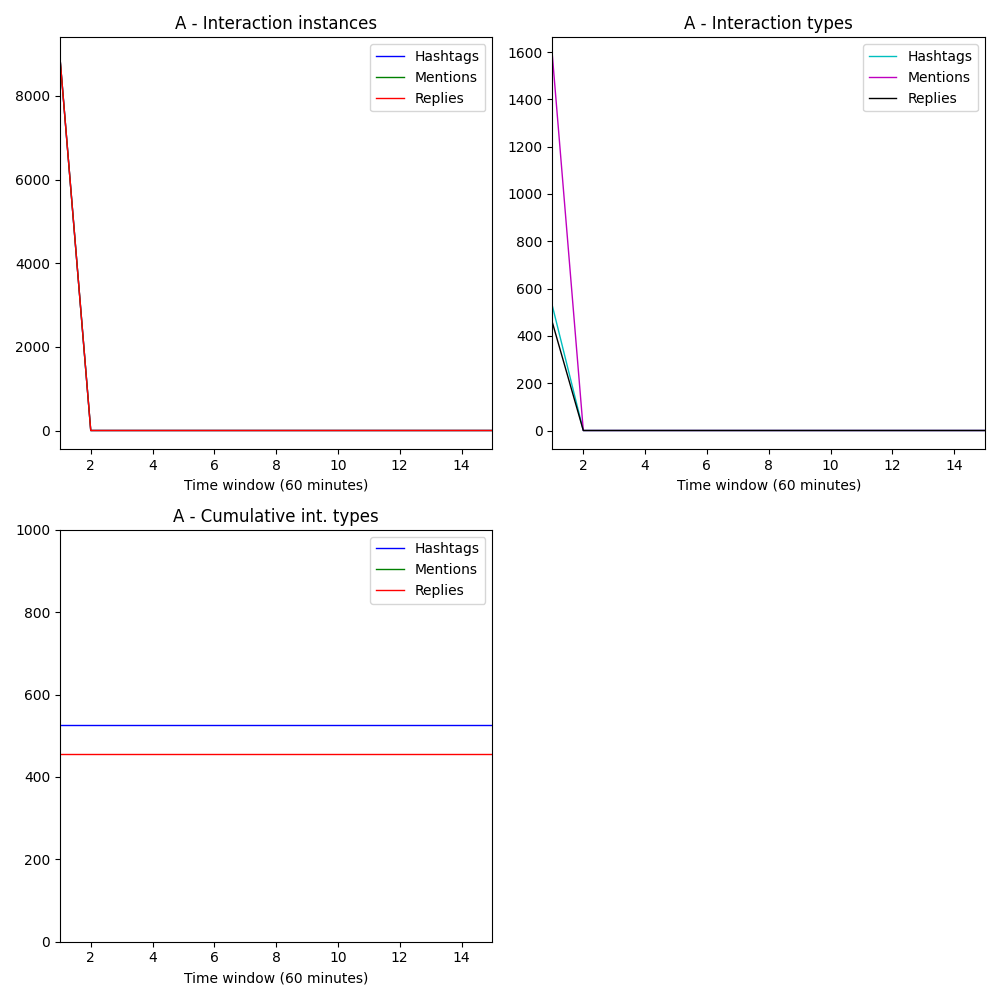

### Plotting gephi networks

#### Mentions

##### Part_1

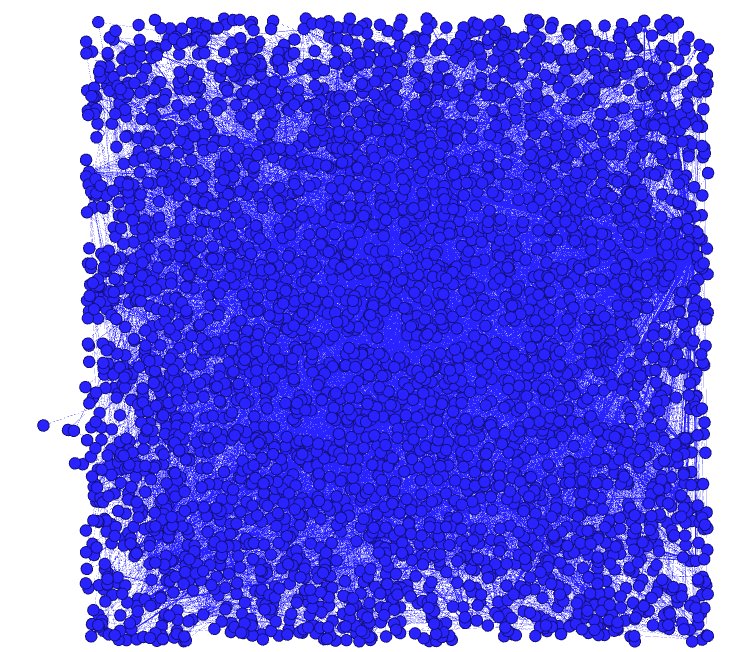

##### Statistics obtained from Gephi

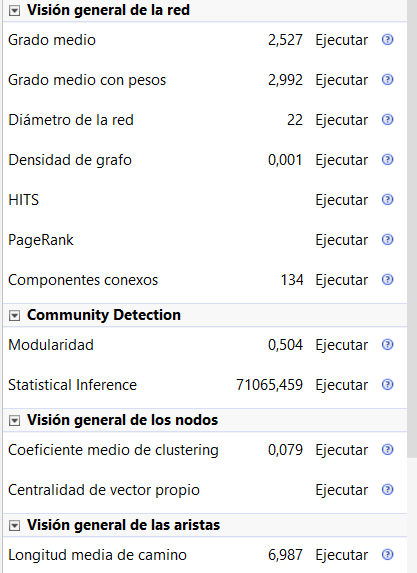

#####  Degree distribution

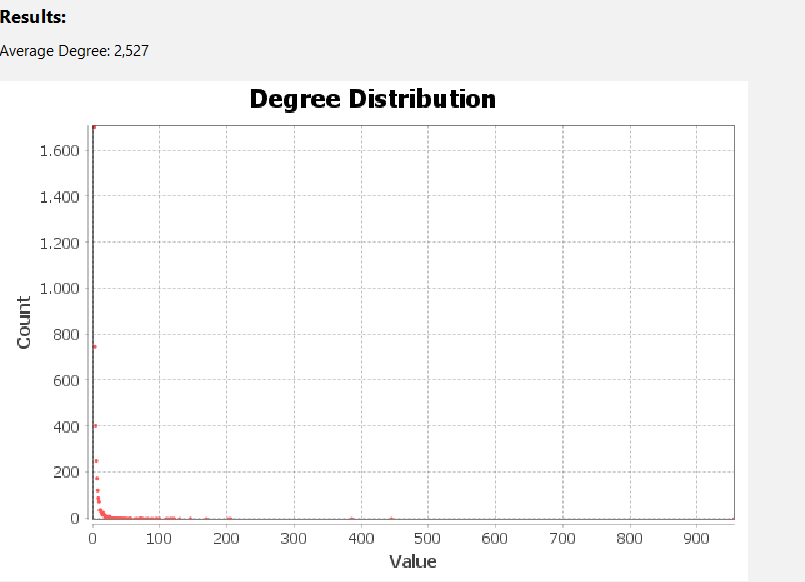

##### Betweness Centrality Distribution

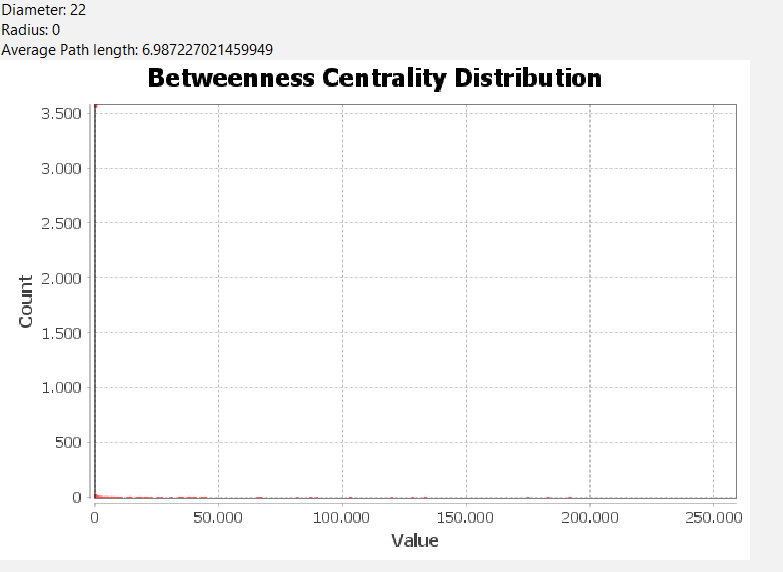

##### Closeness Centrality Distribution

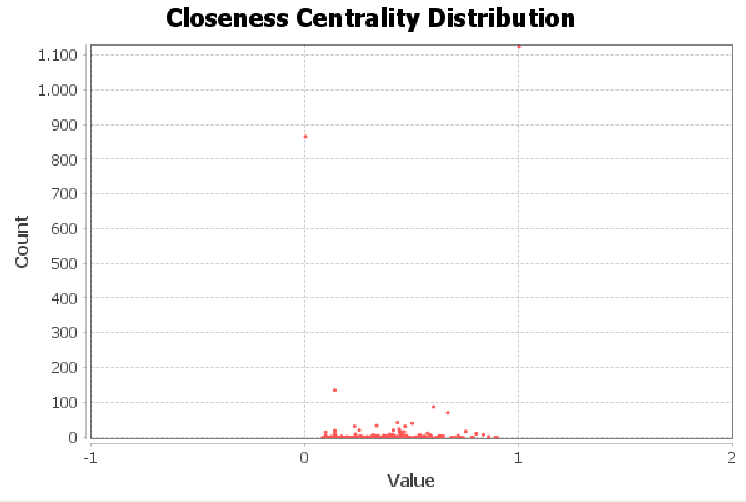

##### Harmonic Closeness Centrality Distribution

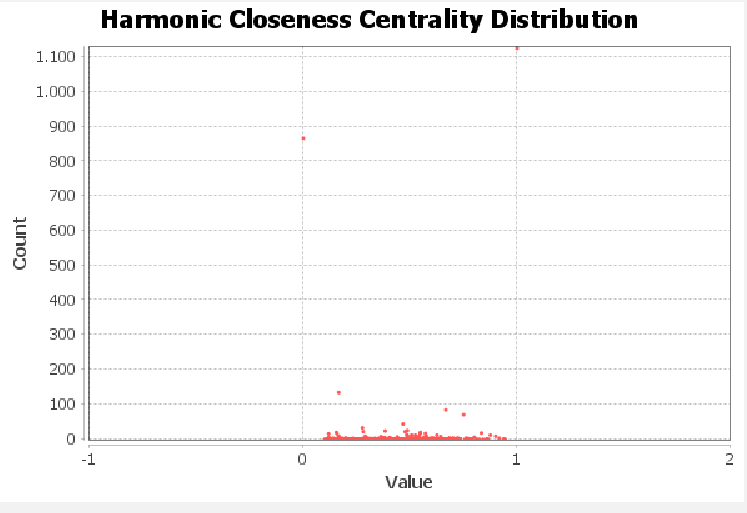

##### Eccentricity Distribution

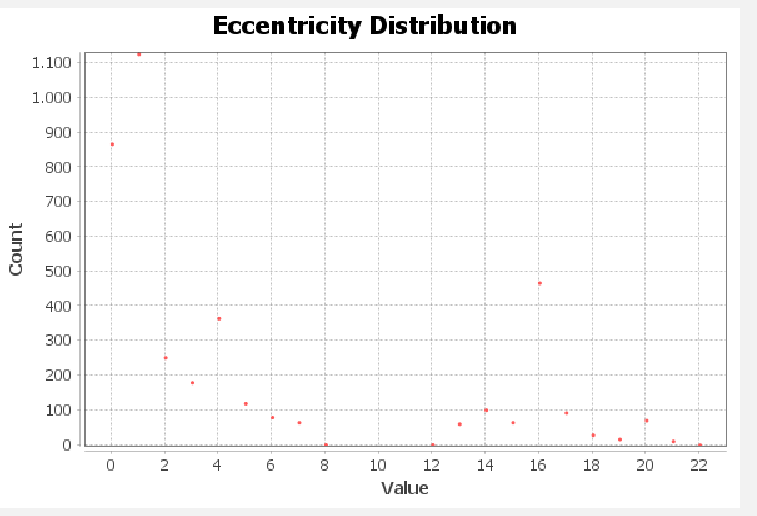

##### Hubs Distribution

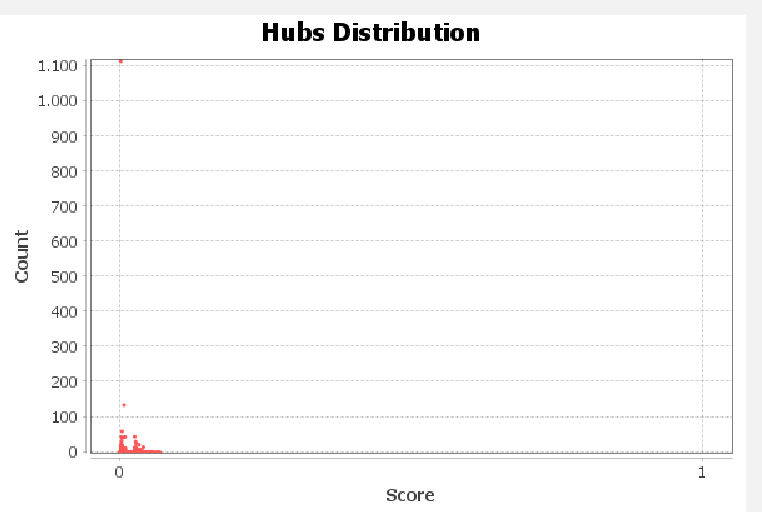

##### Authority Distribution

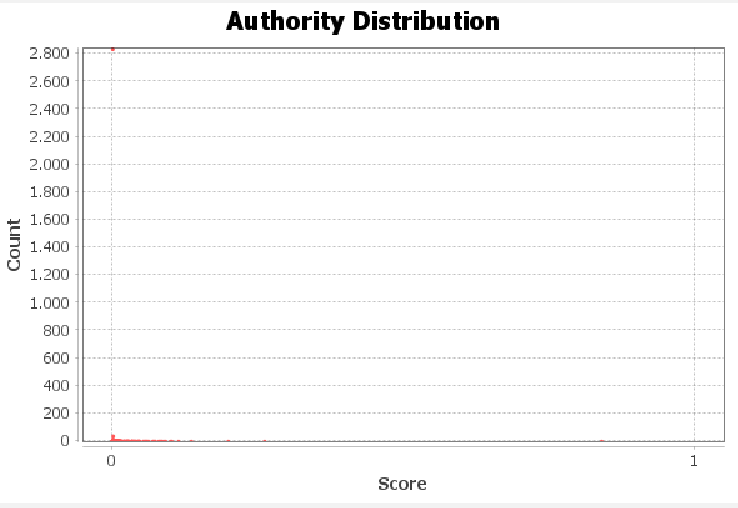

##### Size Distribution

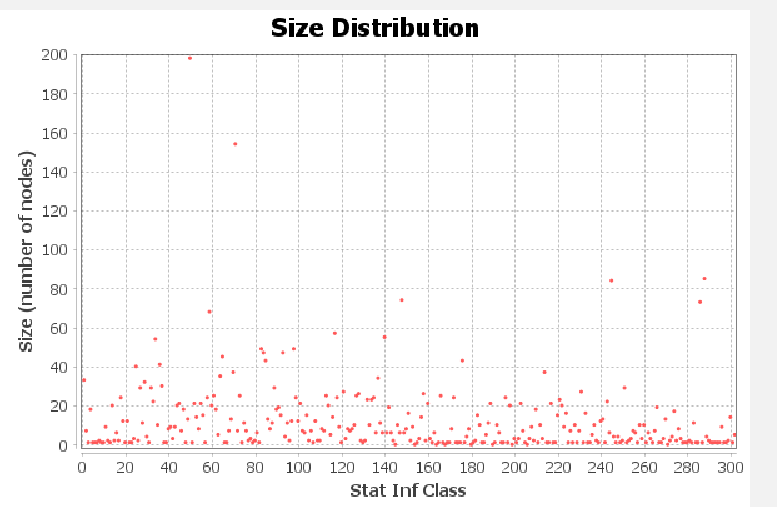

#### Part_2

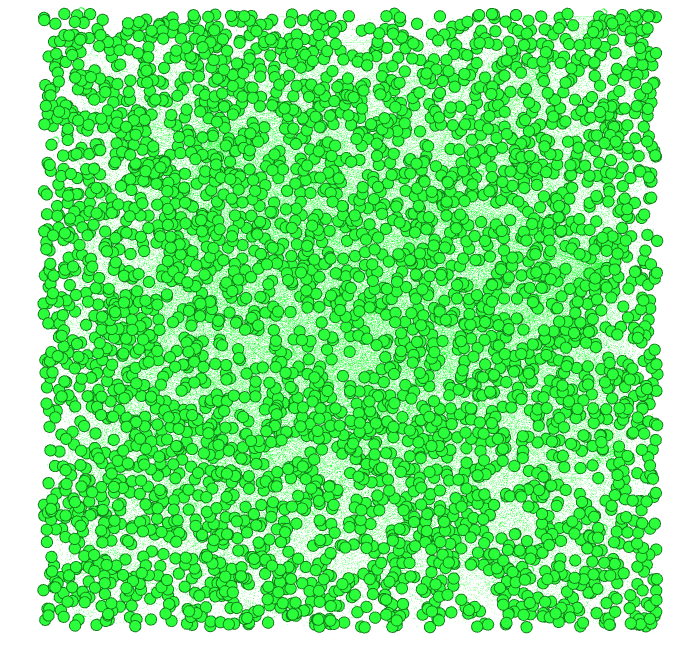

##### Statistics obtained from Gephi

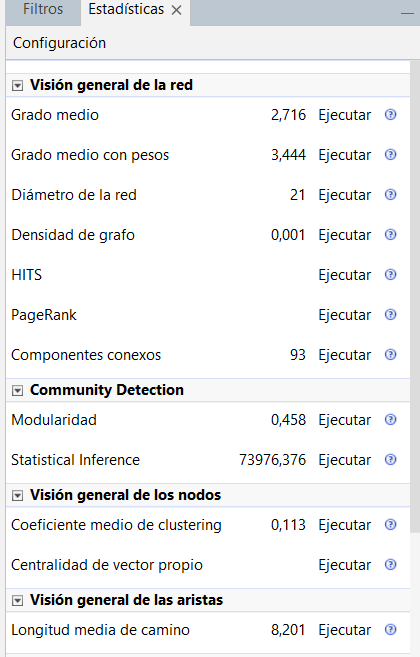

#####  Degree distribution

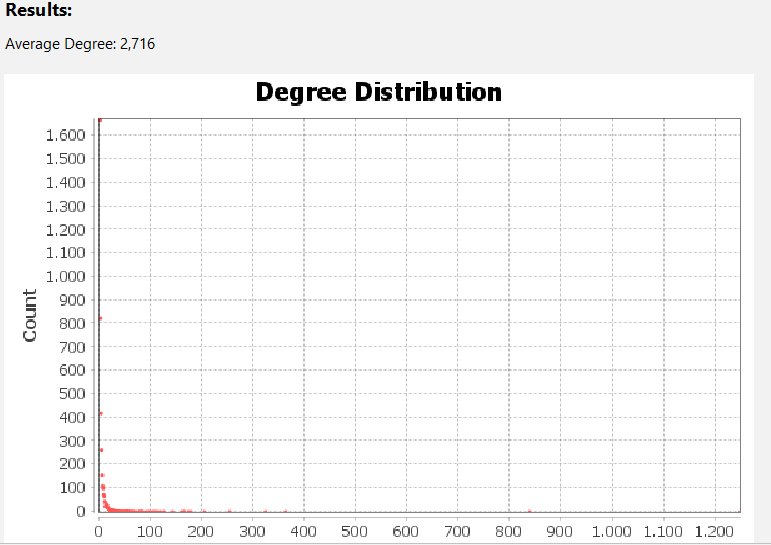

##### Betweness Centrality Distribution

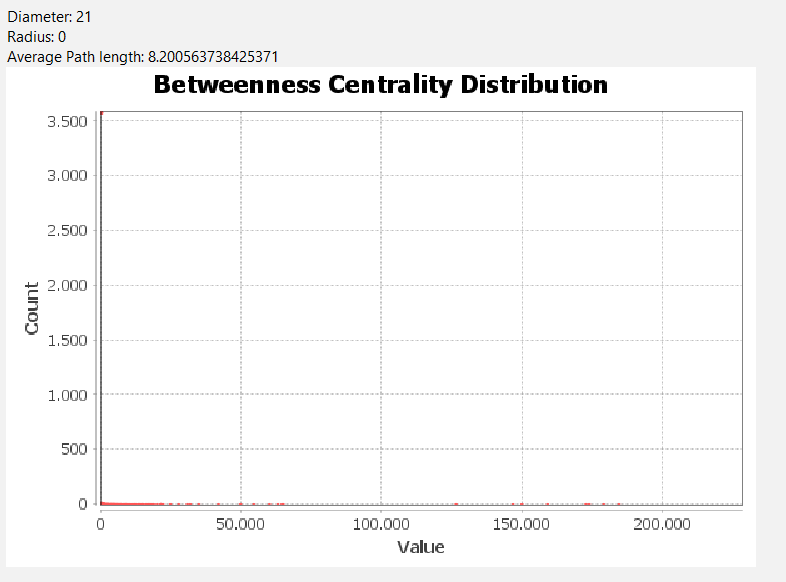

##### Closeness Centrality Distribution

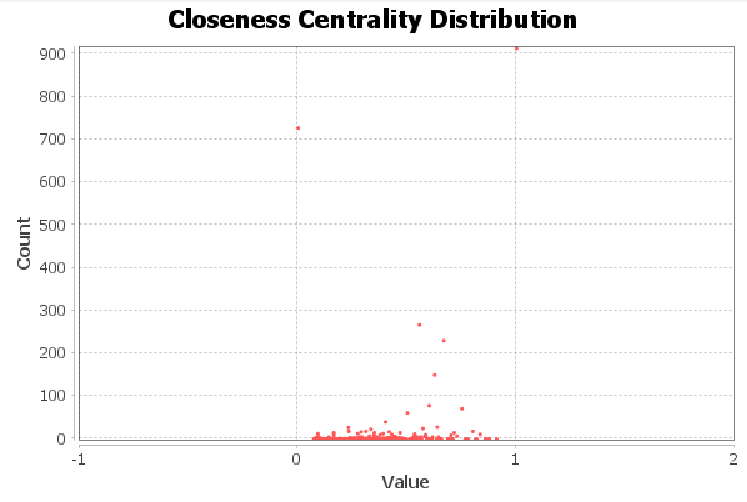

##### Harmonic Closeness Centrality Distribution

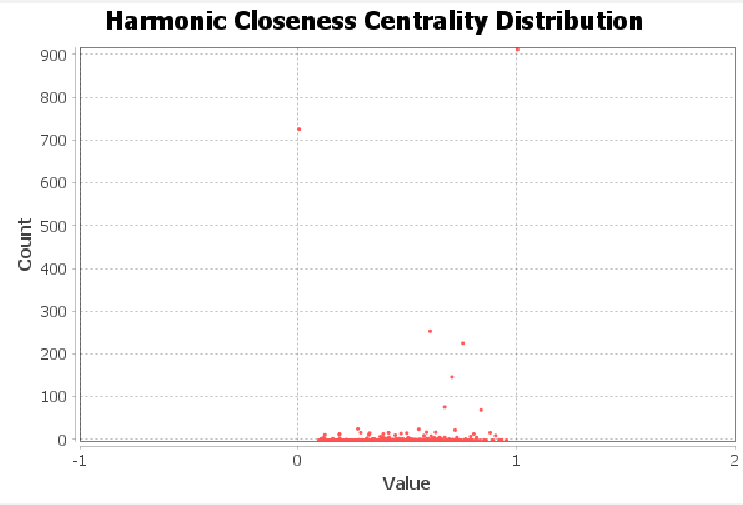

##### Eccentricity Distribution

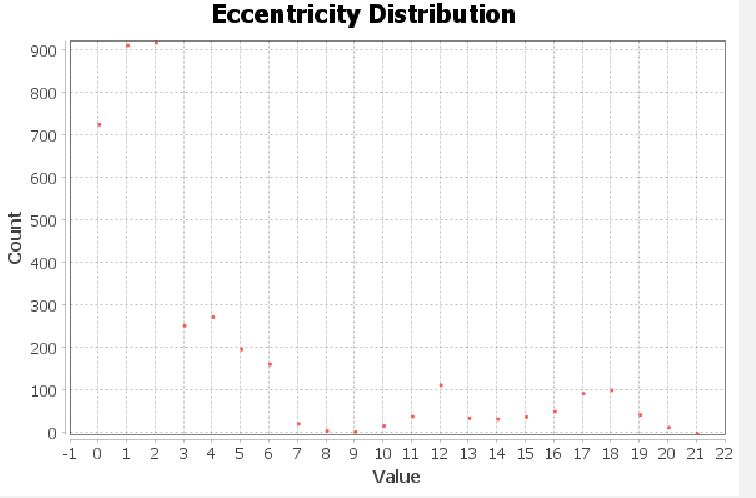

##### Hubs Distribution

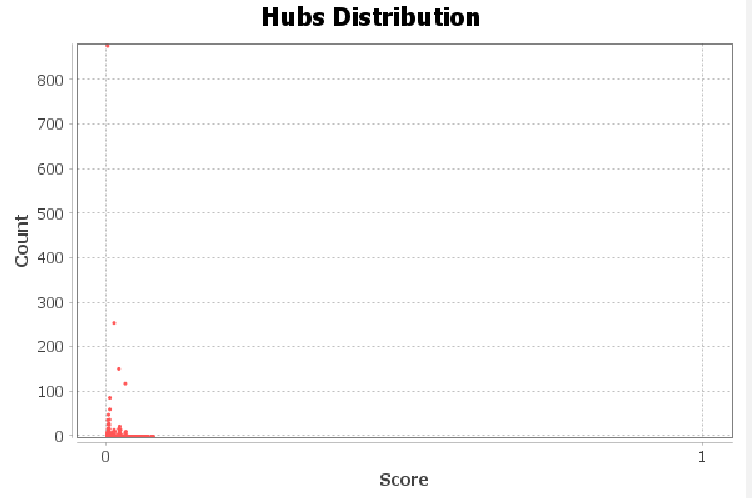

##### Authority Distribution

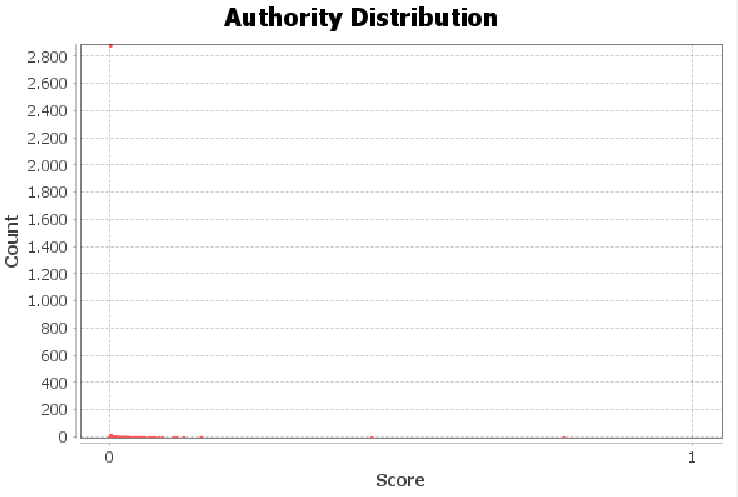

##### Size Distribution

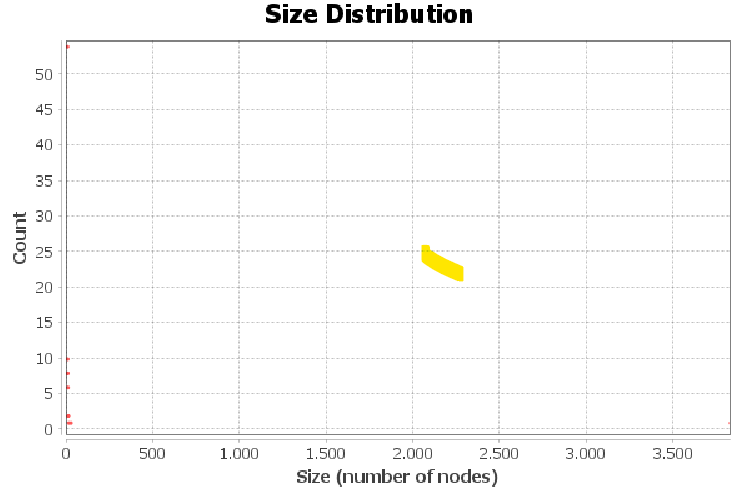

#### Replies

##### Part_1

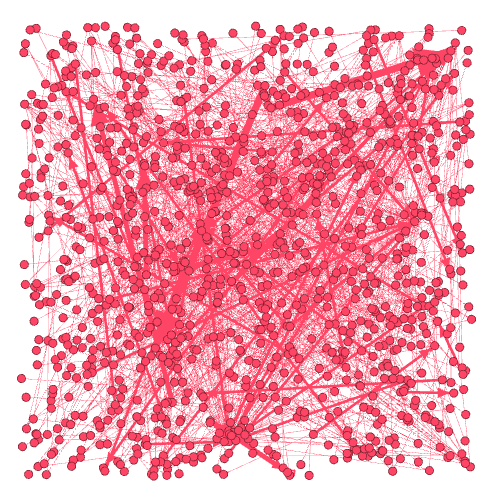

##### Statistics obtained from Gephi

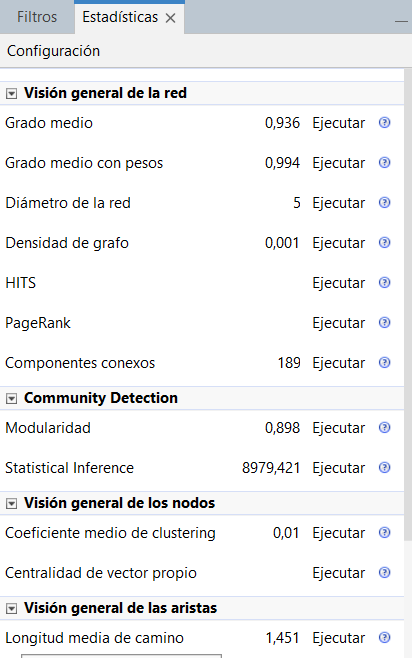

#####  Degree distribution

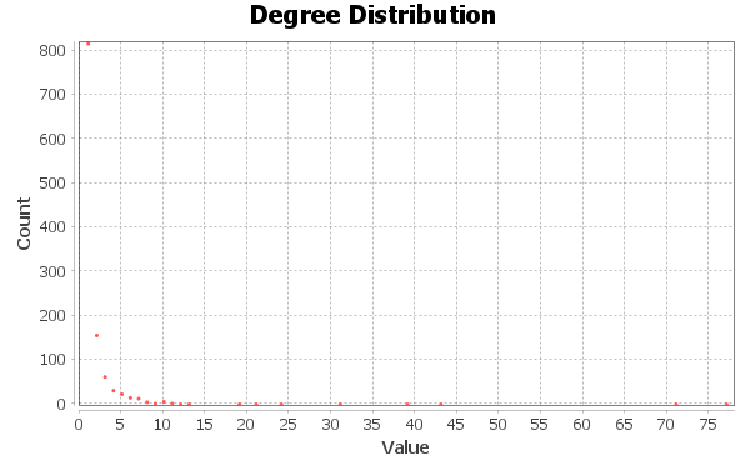

##### Betweness Centrality Distribution

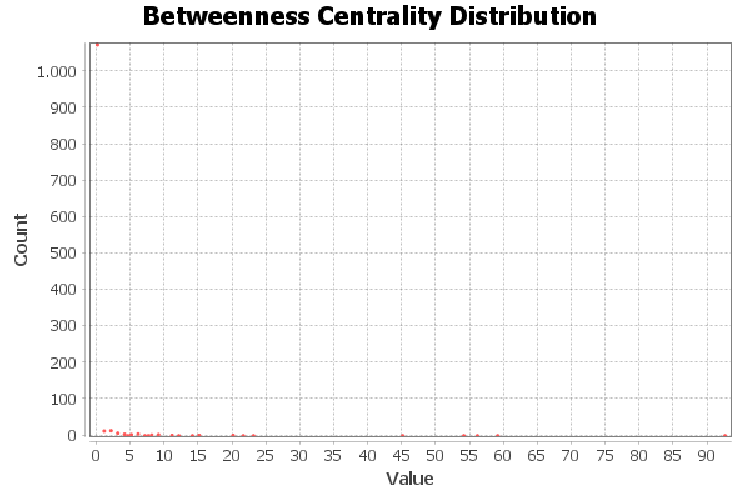

##### Closeness Centrality Distribution

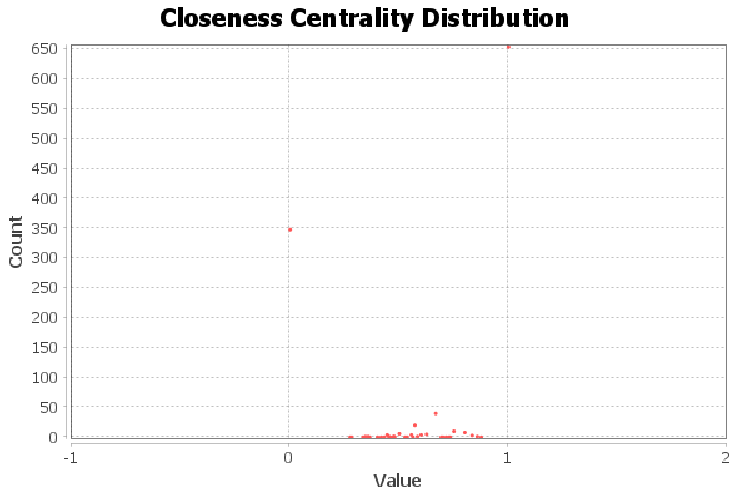

##### Harmonic Closeness Centrality Distribution

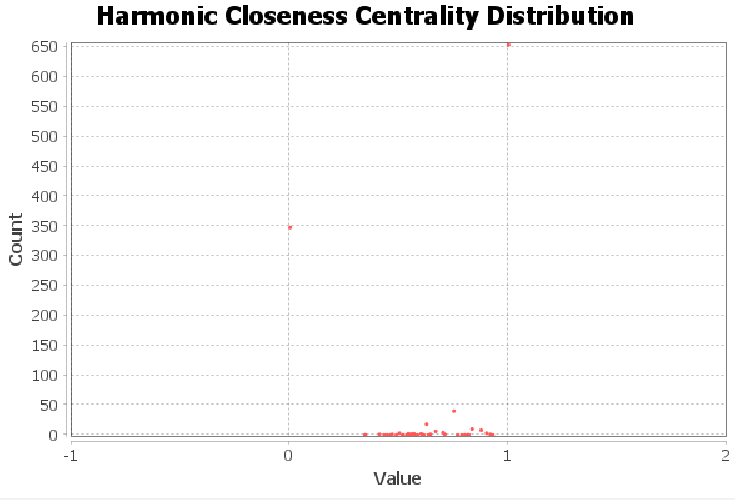

##### Eccentricity Distribution

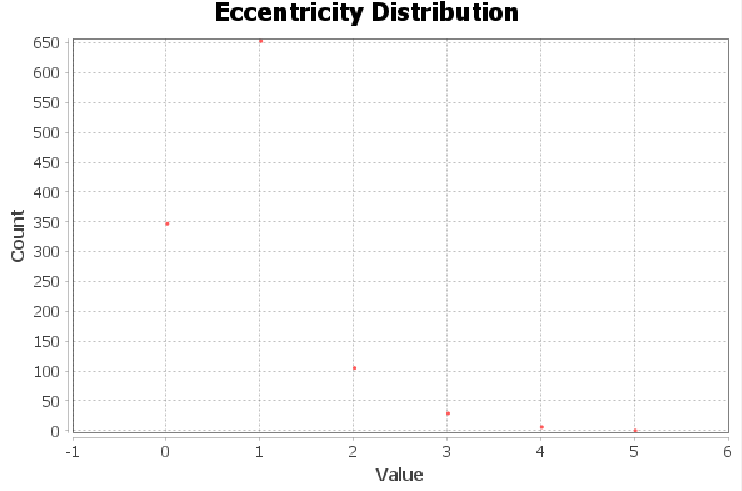

##### Hubs Distribution

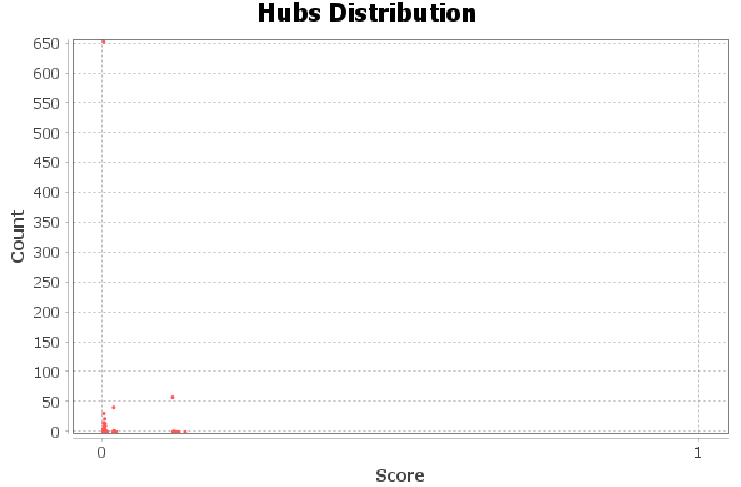

##### Authority Distribution

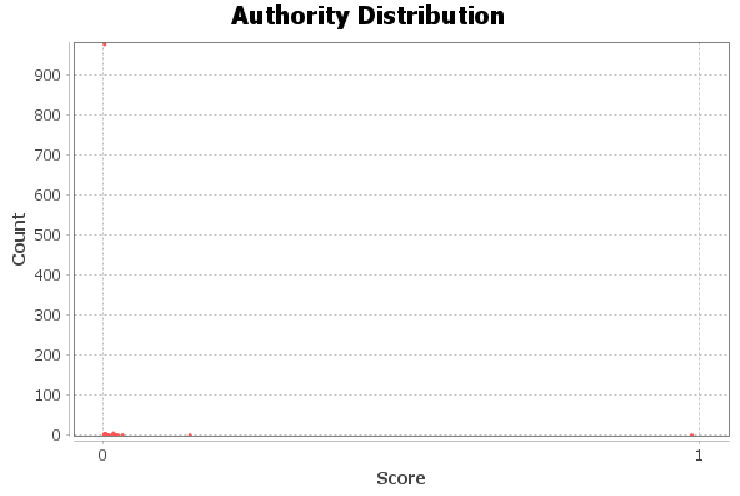

##### Size Distribution

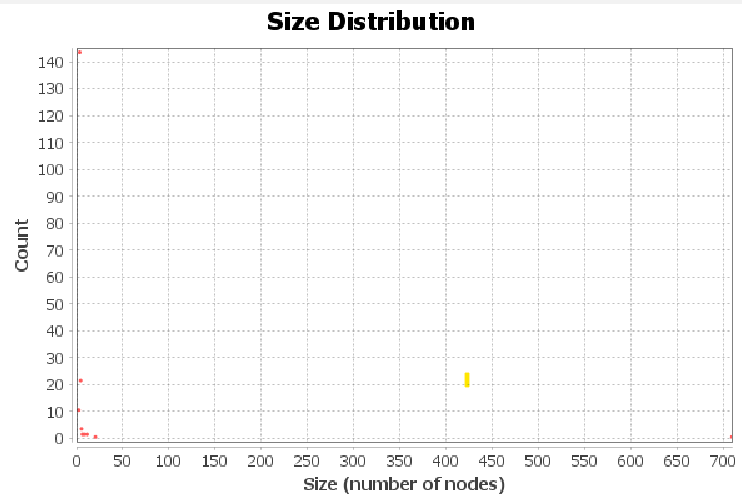

#### Part_2

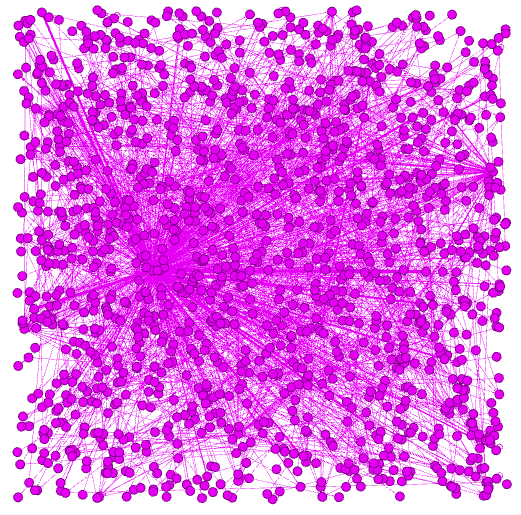

##### Statistics obtained from Gephi

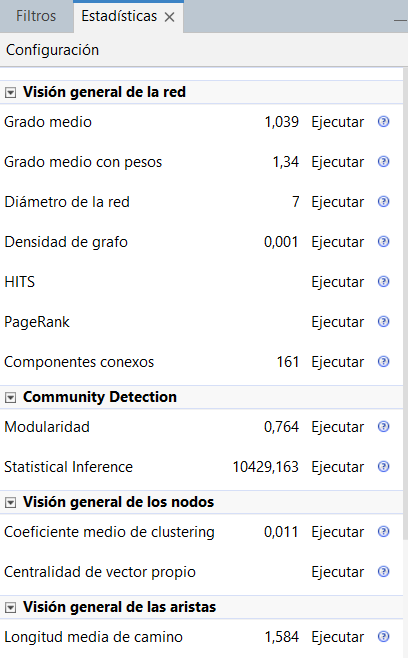

#####  Degree distribution

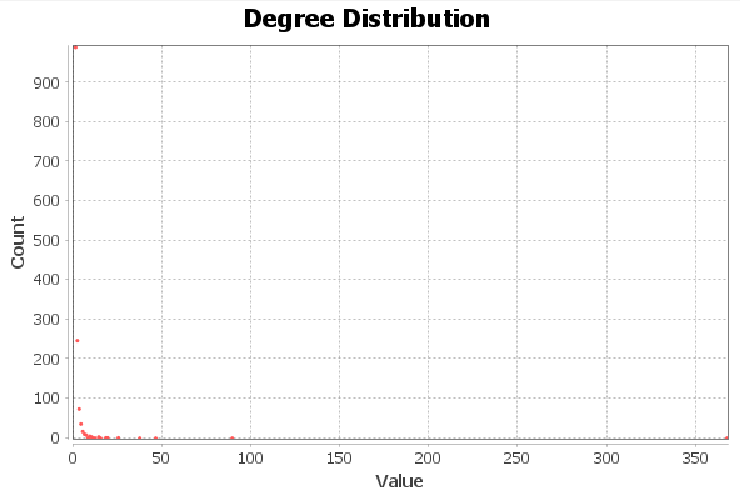

##### Betweness Centrality Distribution

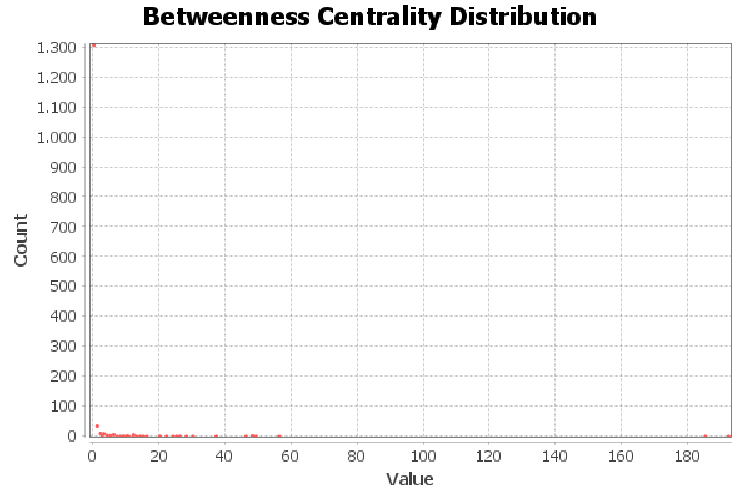

##### Closeness Centrality Distribution

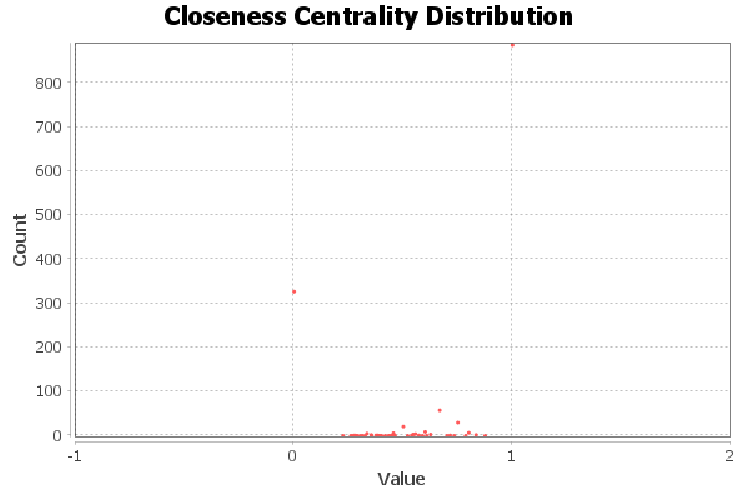

##### Harmonic Closeness Centrality Distribution

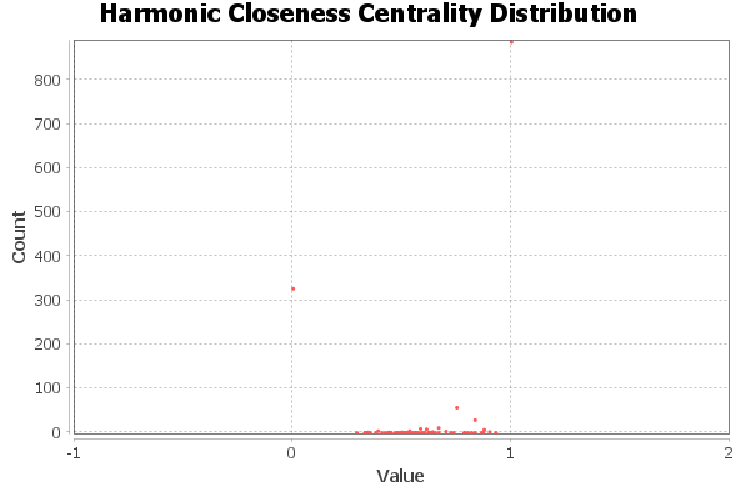

##### Eccentricity Distribution

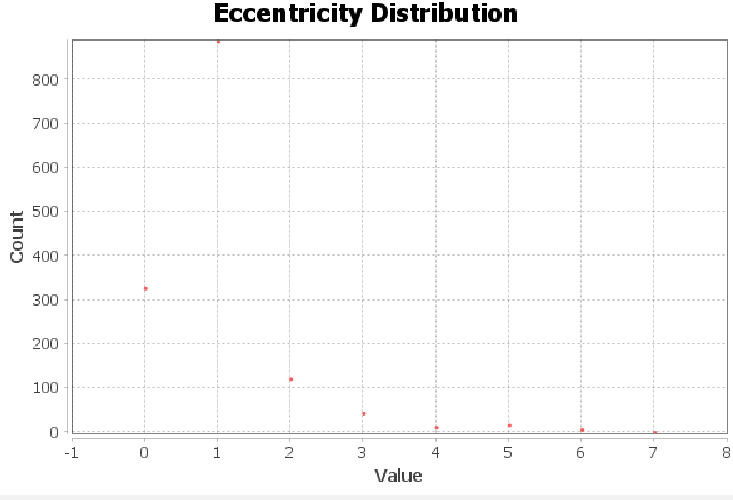

##### Hubs Distribution

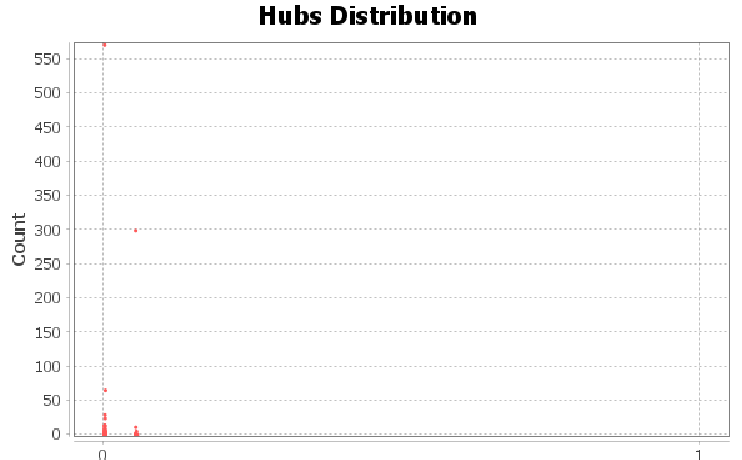

##### Authority Distribution

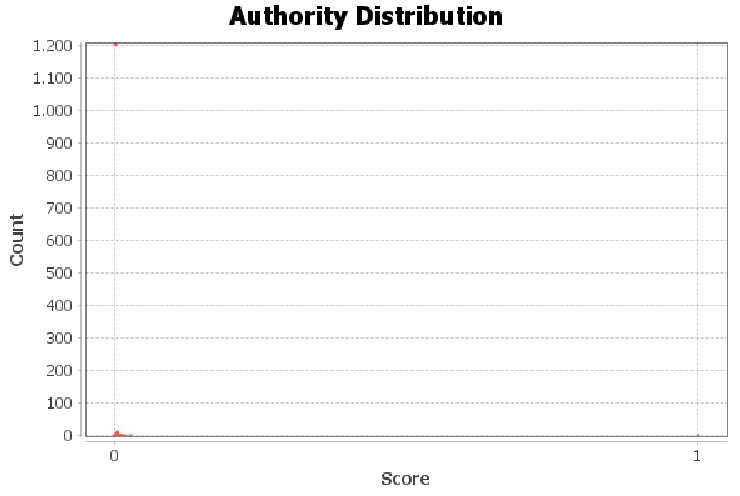

##### Size Distribution

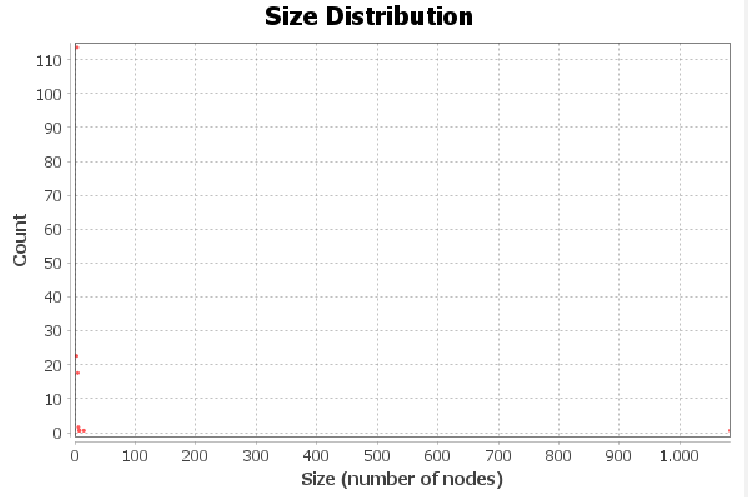

#### Hashtags

##### Part_1

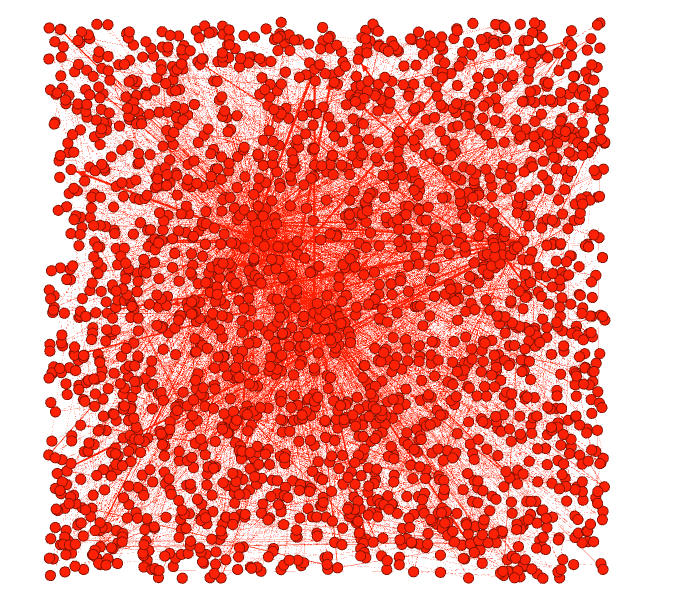

##### Statistics obtained from Gephi

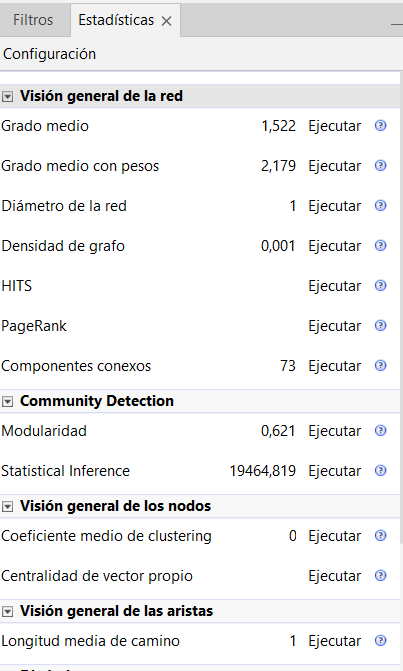

#####  Degree distribution

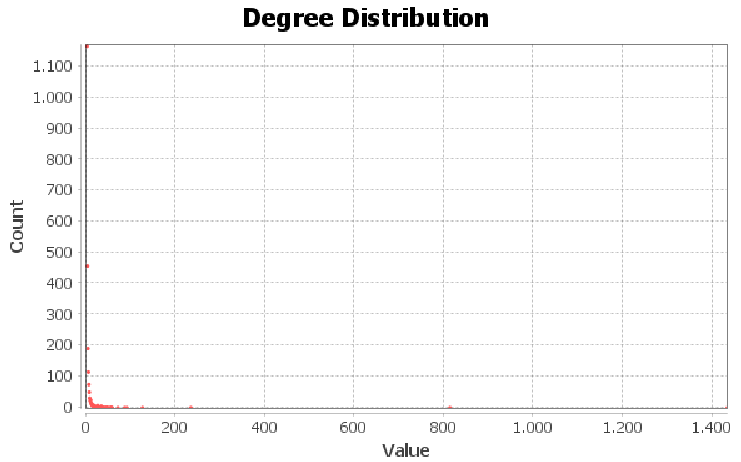

##### Betweness Centrality Distribution

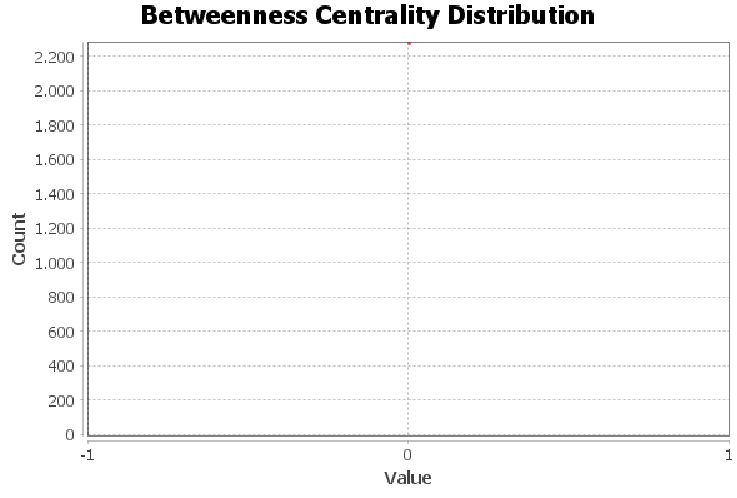

##### Closeness Centrality Distribution

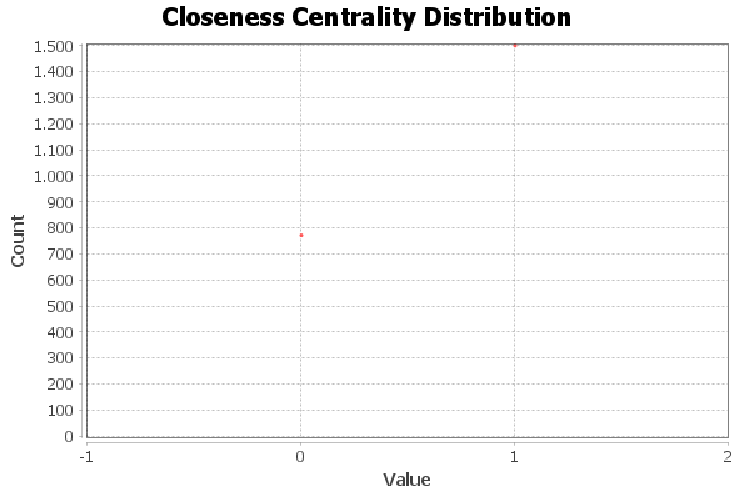

##### Harmonic Closeness Centrality Distribution

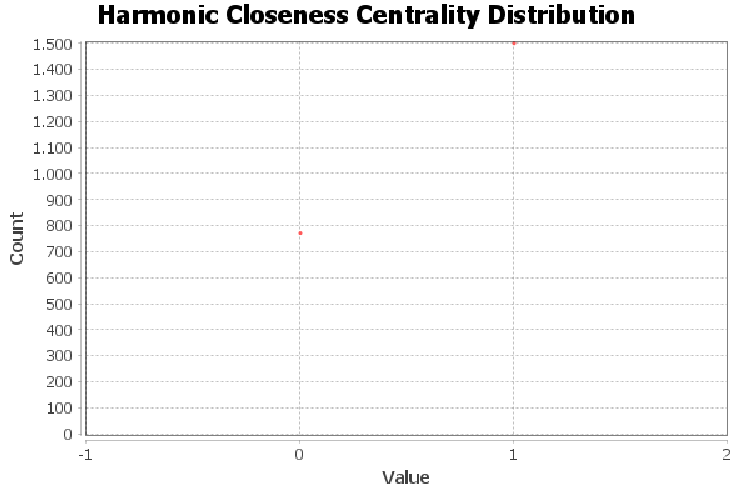

##### Eccentricity Distribution

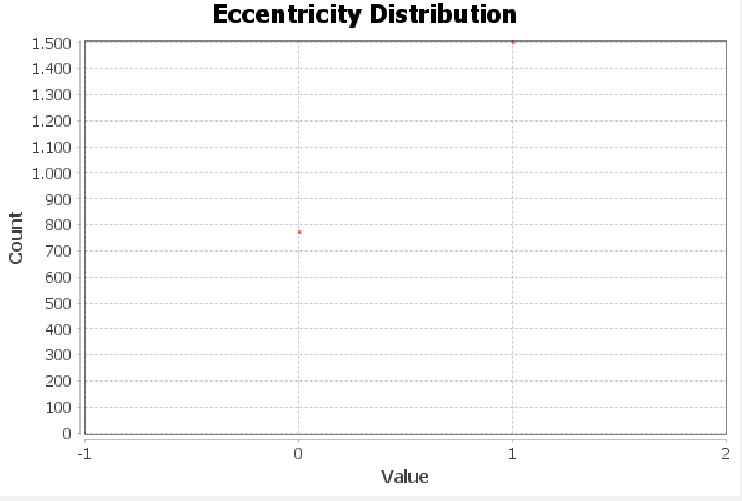

##### Hubs Distribution

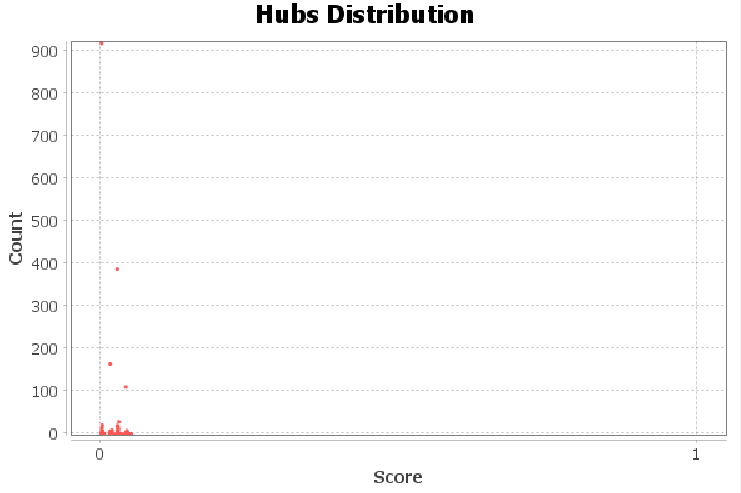

##### Authority Distribution

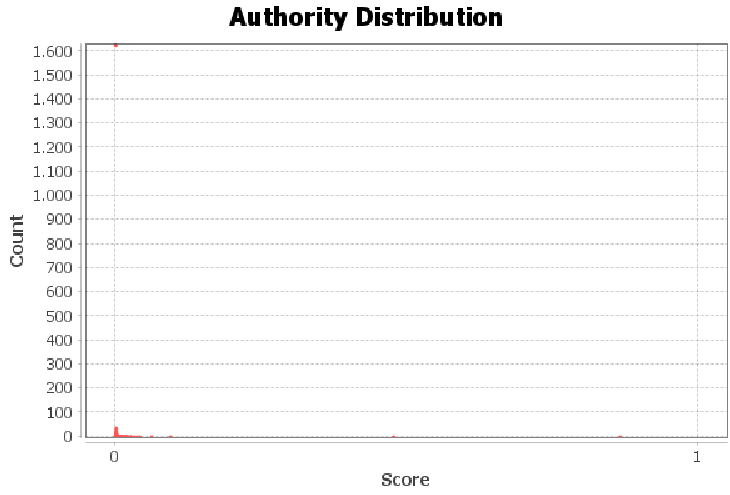

##### Size Distribution

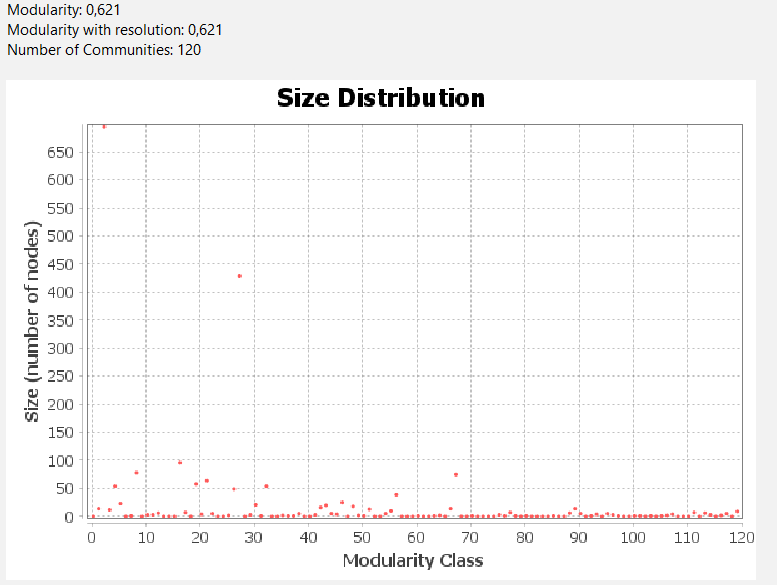

#### Part_2

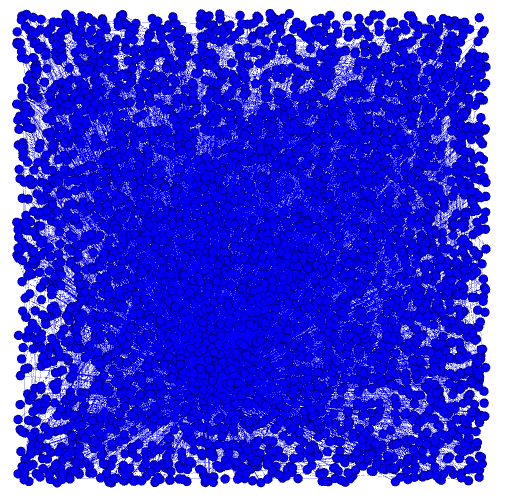

##### Statistics obtained from Gephi

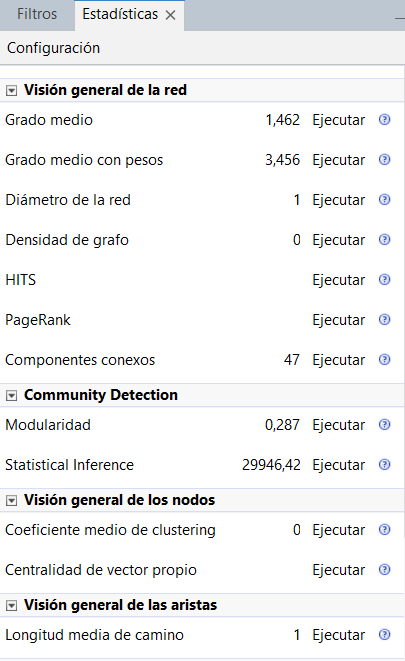

#####  Degree distribution

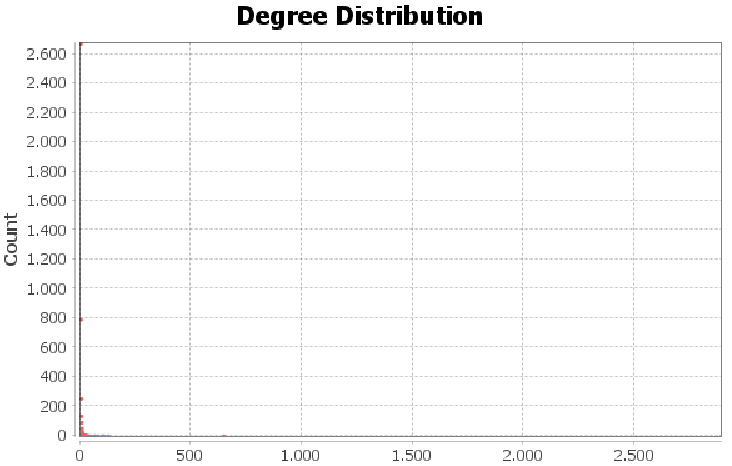

##### Betweness Centrality Distribution

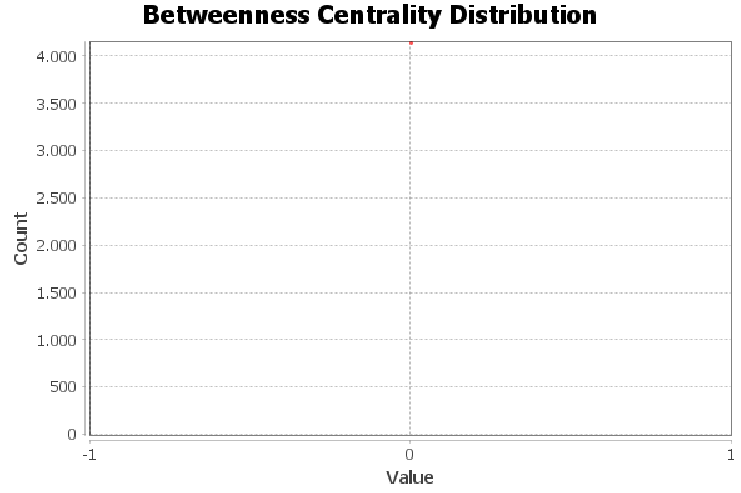

##### Closeness Centrality Distribution

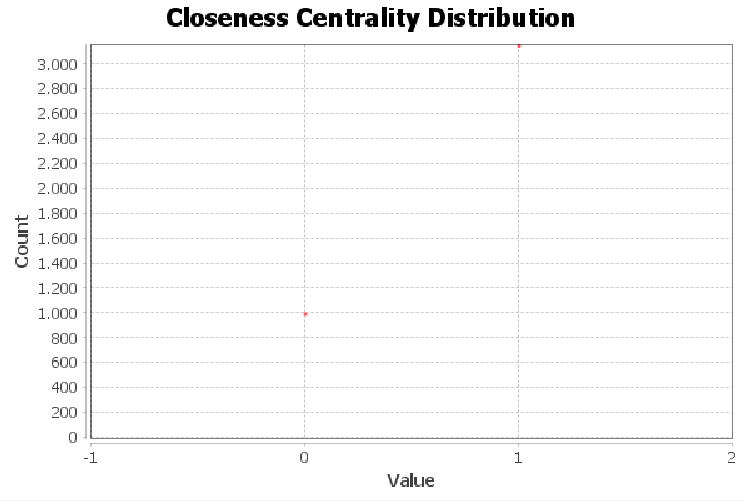

##### Harmonic Closeness Centrality Distribution

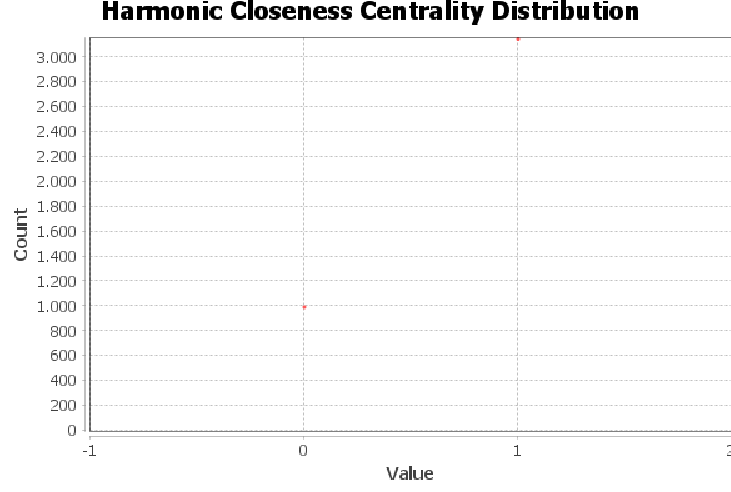

##### Eccentricity Distribution

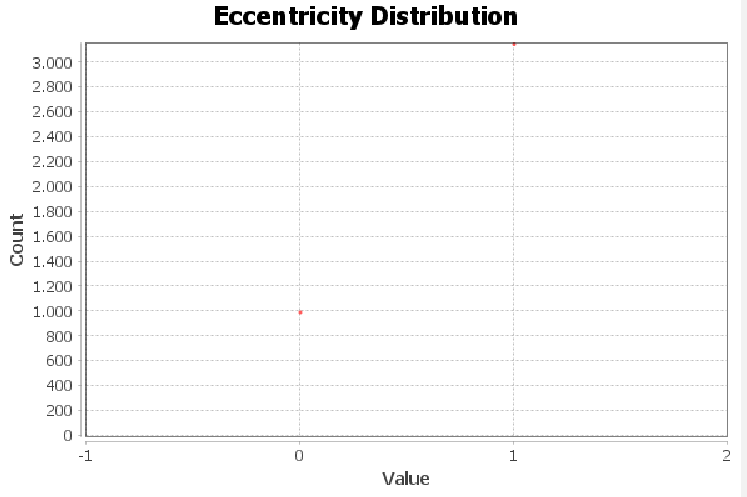

##### Hubs Distribution

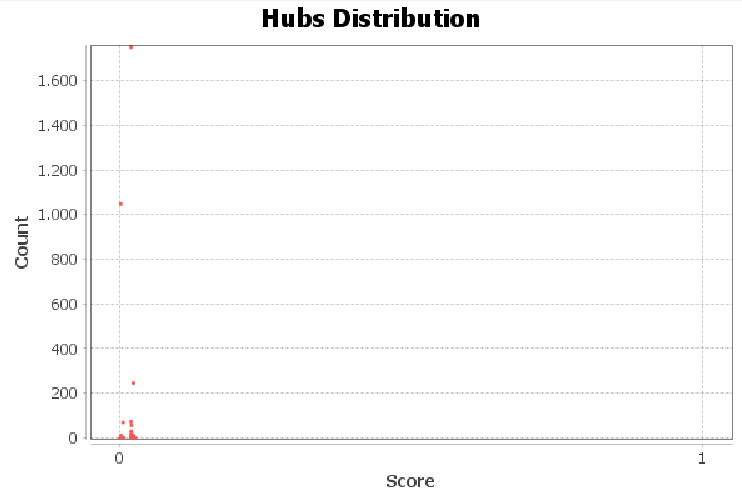

##### Authority Distribution

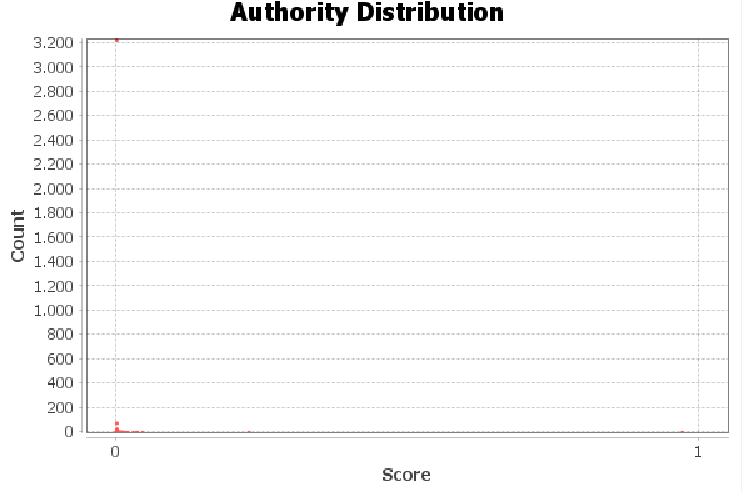

##### Size Distribution

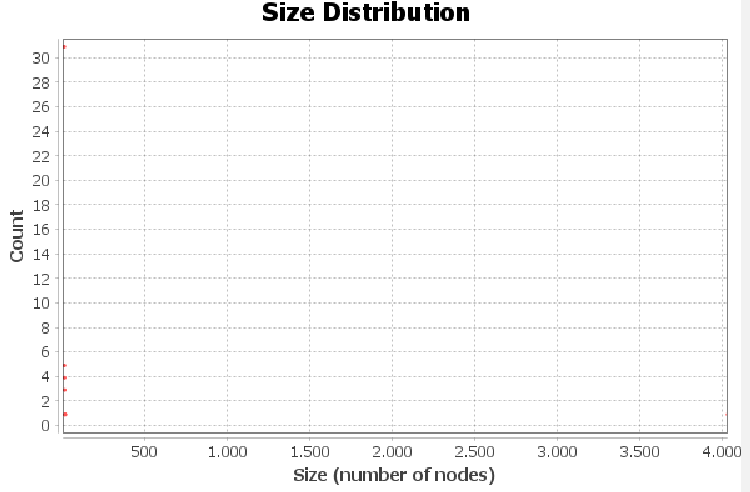